# Weather Impact on Traffic Accidents

## Problem Statement
For this project, I aim to determine if inclement weather causes more frequent and severe accidents compared to clear and sunny weather. Understanding this relationship can inform public safety campaigns, resource allocation for emergency services, and urban planning initiatives aimed at improving road safety during poor weather conditions. 


## Step 1: Gather Data

### Dataset 1:

I will be utilizing the "Motor Vehicle Collisions - Crashes" dataset because it provides comprehensive historical data on motor vehicle accidents in New York City. Its detailed records, including crash dates and locations, are essential for correlating accident occurrences with specific weather conditions. This dataset's breadth allows for an in-depth analysis of both the frequency and severity of collisions across the city.

Dataset Type: CSV

Data Wrangling Method: The data is gathered by programmatically downloading files from the NYC Open Data Portal

Dataset variables that will be used:

 - **CRASH DATE**: Date the collision occured
 - **CRASH TIME**: Time the collision occured
 - **LATITUDE**: Latitude coordinate of the collision
 - **LONGITUDE**: Longitude coordinate of the collision
 - **NUMBER OF PERSONS INJURED**: Amount of total injuries in collision
 - **NUMBER OF PERSONS KILLED**: Amount of total fatalities in collision
 - **COLLISION_ID**: Unique identifier for the collision


In [ ]:
# Imports required for workbook
import pandas as pd
import numpy as np
import requests
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

In [2]:
# Load in first dataset

# URL for the CSV version of the dataset
csv_url = "https://data.cityofnewyork.us/api/views/h9gi-nx95/rows.csv?accessType=DOWNLOAD"

# Defines a filename to save the dataset to
file_name = "motor_vehicle_collisions_subset.csv"

try:
    # Use pandas to read a limited number of rows directly from the URL.
    # The `nrows` parameter is key to grabbing only a small chunk of the data,
    # avoiding the large file size issue.
    print(f"Reading the first 100,000 records from {csv_url}...")
    motor_accident_df = pd.read_csv(csv_url, nrows=100000)
    
    # Save the smaller DataFrame to a new CSV file
    motor_accident_df.to_csv(file_name, index=False)
    print(f"Successfully created a subset and saved it to {file_name}")

    # Display the number of rows to confirm the result
    print(f"The DataFrame now contains {len(motor_accident_df)} rows.")

except requests.exceptions.RequestException as e:
    print(f"Error accessing the data URL: {e}")
except Exception as e:
    print(f"An error occurred: {e}")


Reading the first 100,000 records from https://data.cityofnewyork.us/api/views/h9gi-nx95/rows.csv?accessType=DOWNLOAD...
Successfully created a subset and saved it to motor_vehicle_collisions_subset.csv
The DataFrame now contains 100000 rows.


### Dataset 2:

I will be utilizing the Open-Meteo Historical Weather API dataset for its comprehensive and freely accessible historical weather data, which is curcial for identifying correlations with past motor vehicle collisions. It contains detailed daily weather variables (like temperature, precipitation, and wind) for specific geographical coordinates and extensive date ranges. This will allow for a robust investigation into how different weather conditions might influence accident frequency and severity in New York City.

Dataset Type: JSON

Data Wrangling Method: The data is gathered by utilizing the Open-Meteo Historical Weather API

Dataset variables that will be used:

*    **time:** Date the weather data was recorded
*    **temperature_2m_max:** Maximum daily air temperature 2 meters above ground
*    **temperature_2m_min:** Minimum daily air temperature 2 meters above ground
*    **precipitation_sum:** Total daily sum of precipitation
*    **rain_sum:** Total daily sum of rain only
*    **snowfall_sum:** Total daily sum of snow only
*    **precipitation_hours:** Number of hours with any type of precipitation on that day
*    **weather_code:** Numerical code that summarizes the overall daily weather condition
*    **wind_speed_10m_max:** Maximum daily wind speed 10 meters above ground
*    **wind_gusts_10m_max:** Maximum daily wind gust (sudden, brief increase in wind speed) at 10 meters above ground
*    **wind_direction_10m_dominant:** Dominant daily wind direction 10 meters above ground


> The first thing I do is create a function called **get_open_meteo_historical_weather** that takes in latitude, longitude, start_date, end_date, and daily_variables which is set to **None** initially to make the parameter optional and allow the function to define a fresh default list of variables if the caller doesnt provide the function a list of desired daily_variables

In [3]:
def get_open_meteo_historical_weather(latitude, longitude, start_date, end_date, daily_variables=None):

    base_url = "https://archive-api.open-meteo.com/v1/archive"

    # If no daily_variable is provided by caller, the function sets this to grab useful weather data
    if daily_variables is None:
        daily_variables = [
            "temperature_2m_max",
            "temperature_2m_min",
            "precipitation_sum",
            "rain_sum",
            "snowfall_sum",
            "precipitation_hours",
            "weather_code",
            "wind_speed_10m_max",
            "wind_gusts_10m_max",
            "wind_direction_10m_dominant"
        ]

    # Sets parameters to be used using the information entered into function
    params = {
        "latitude": latitude,
        "longitude": longitude,
        "start_date": start_date,
        "end_date": end_date,
        "daily": ",".join(daily_variables),
        "timezone": "America/New_York" # Set timezone for accurate day boundaries
    }   

    print(f"Fetching weather data for {start_date} to {end_date} at Lat: {latitude}, Lon: {longitude}")

    try: 

        # Sends a request to the url and stores the information retrieved in response variable
        response = requests.get(base_url, params=params)

        # Raises an HTTPError for bad responses (4XX or 5XX Codes)
        response.raise_for_status()
        data = response.json()

        # Checks to see if the API response contains the key 'daily'
        if "daily" in data:

            # Extracts value associated with the 'daily' key
            daily_data = data['daily']

            # Converts daily_data dictionary inro a Pandas DataFrame
            weather_data_df = pd.DataFrame(daily_data)

            return weather_data_df
        
        else:

            # Print response for debugging if the 'daily' ket is not found
            print("No 'daily' data found in the API response. Check parameters or date range")
            print("API Response:", data)
            return None
        
    except requests.exceptions.RequestException as e:
        print(f"Error fetching data from Open-Meteo API: {e}")
        return None
    except Exception as e:
        print(f"An unexpected error occured: {e}")
        return None


In [4]:
# Load in dataset 2
# Coordinates for Central Park, NYC (approximate)
nyc_latitude = 40.7831
nyc_longitude = -73.9712

# Sets a desired data range to compare to motor collision dataset
start_date = "2012-07-01"
end_date = "2025-05-28"

# Fetch the data using the created function
nyc_weather_df = get_open_meteo_historical_weather(
    nyc_latitude,
    nyc_longitude,
    start_date,
    end_date
)

# Prints messsage stating if data was retrieved or not and stores file in CSV file once obtained
if nyc_weather_df is not None:
    print("NYC historical weather data has been successfully retrieved")

    # Defines the gile name for weather data CSV
    weather_file_name = "nyc_historical_weather.csv"

    # Converts file to CSV
    nyc_weather_df.to_csv(weather_file_name, index=True)
else:
    print("Failed to retrieve NYC historcal weather data.")


Fetching weather data for 2012-07-01 to 2025-05-28 at Lat: 40.7831, Lon: -73.9712
NYC historical weather data has been successfully retrieved


## Step 2: Assess Data

> I first perform basic data inspection using the .info() and .head() funcitons to get an idea of what the data looks like in my datasets.

In [5]:
motor_accident_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 29 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   CRASH DATE                     100000 non-null  object 
 1   CRASH TIME                     100000 non-null  object 
 2   BOROUGH                        65611 non-null   object 
 3   ZIP CODE                       65600 non-null   float64
 4   LATITUDE                       92061 non-null   float64
 5   LONGITUDE                      92061 non-null   float64
 6   LOCATION                       92061 non-null   object 
 7   ON STREET NAME                 72876 non-null   object 
 8   CROSS STREET NAME              46361 non-null   object 
 9   OFF STREET NAME                27123 non-null   object 
 10  NUMBER OF PERSONS INJURED      100000 non-null  int64  
 11  NUMBER OF PERSONS KILLED       100000 non-null  int64  
 12  NUMBER OF PEDESTRIANS INJURED  

In [6]:
motor_accident_df.head()

,CRASH DATE,CRASH TIME,BOROUGH,ZIP CODE,LATITUDE,LONGITUDE,LOCATION,ON STREET NAME,CROSS STREET NAME,OFF STREET NAME,...,CONTRIBUTING FACTOR VEHICLE 2,CONTRIBUTING FACTOR VEHICLE 3,CONTRIBUTING FACTOR VEHICLE 4,CONTRIBUTING FACTOR VEHICLE 5,COLLISION_ID,VEHICLE TYPE CODE 1,VEHICLE TYPE CODE 2,VEHICLE TYPE CODE 3,VEHICLE TYPE CODE 4,VEHICLE TYPE CODE 5
0,09/11/2021,2:39,NaN,NaN,NaN,NaN,NaN,WHITESTONE EXPRESSWAY,20 AVENUE,NaN,...,Unspecified,NaN,NaN,NaN,4455765,Sedan,Sedan,NaN,NaN,NaN
1,03/26/2022,11:45,NaN,NaN,NaN,NaN,NaN,QUEENSBORO BRIDGE UPPER,NaN,NaN,...,NaN,NaN,NaN,NaN,4513547,Sedan,NaN,NaN,NaN,NaN
2,11/01/2023,1:29,BROOKLYN,11230.0,40.62179,-73.970024,"(40.62179, -73.970024)",OCEAN PARKWAY,AVENUE K,NaN,...,Unspecified,Unspecified,NaN,NaN,4675373,Moped,Sedan,Sedan,NaN,NaN
3,06/29/2022,6:55,NaN,NaN,NaN,NaN,NaN,THROGS NECK BRIDGE,NaN,NaN,...,Unspecified,NaN,NaN,NaN,4541903,Sedan,Pick-up Truck,NaN,NaN,NaN
4,09/21/2022,13:21,NaN,NaN,NaN,NaN,NaN,BROOKLYN BRIDGE,NaN,NaN,...,Unspecified,NaN,NaN,NaN,4566131,Station Wagon/Sport Utility Vehicle,NaN,NaN,NaN,NaN


In [7]:
nyc_weather_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4715 entries, 0 to 4714
Data columns (total 11 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   time                         4715 non-null   object 
 1   temperature_2m_max           4715 non-null   float64
 2   temperature_2m_min           4715 non-null   float64
 3   precipitation_sum            4715 non-null   float64
 4   rain_sum                     4715 non-null   float64
 5   snowfall_sum                 4715 non-null   float64
 6   precipitation_hours          4715 non-null   float64
 7   weather_code                 4715 non-null   int64  
 8   wind_speed_10m_max           4715 non-null   float64
 9   wind_gusts_10m_max           4715 non-null   float64
 10  wind_direction_10m_dominant  4715 non-null   int64  
dtypes: float64(8), int64(2), object(1)
memory usage: 405.3+ KB


In [8]:
nyc_weather_df.head()

,time,temperature_2m_max,temperature_2m_min,precipitation_sum,rain_sum,snowfall_sum,precipitation_hours,weather_code,wind_speed_10m_max,wind_gusts_10m_max,wind_direction_10m_dominant
0,2012-07-01,34.8,20.1,1.7,1.7,0.0,1.0,61,17.0,37.1,268
1,2012-07-02,31.0,19.7,0.0,0.0,0.0,0.0,2,14.0,26.3,321
2,2012-07-03,31.9,18.6,0.0,0.0,0.0,0.0,3,12.1,25.6,269
3,2012-07-04,33.7,20.5,3.9,3.9,0.0,4.0,61,10.9,26.3,251
4,2012-07-05,34.9,24.3,0.0,0.0,0.0,0.0,3,14.4,24.1,321


### Quality Issue 1: Mixed Data Types In Motor Accident DataFrame 

The first quality issue that I noticed is that there are some mislabled data types that are in the motor_accident_df. The CRASH DATE and CRASH TYPE are of type object when they should have been assigned as type datetime. Another issue is that both NUMBER OF PERSONS INJURED and NUMBER OF PERSONS KILLED are both assigned as type float when they should have been assigned as type int since it is impossible in injur or kill half of a person for example. 

In [9]:
# Inspecting Motor Accidents DataFrame Programmatically
# Function that sees if there are multiple types in a specific column
def check_mixed_types(series):

    # Filter out all the nulls to type check what is stored
    non_nan_values = series.dropna()

    # Gets the type of each non_NaN value
    unique_types = set(non_nan_values.apply(type))

    return len(unique_types) > 1, unique_types

In [10]:
# List of columns to check data types on
column_names = ['CRASH DATE', 'NUMBER OF PERSONS INJURED', 'NUMBER OF PERSONS KILLED']

#Loop created to run the function on all columns in the above list
for i in column_names:

    # Runs the function using the columns specified in column_names
    is_mixed, types_found = check_mixed_types(motor_accident_df[i])

    # Prints if the column contains mixed type or not
    if is_mixed:
        print(f"Column '{i}': Has Mixed Data Types. Types Found: {types_found}")
    else:
        print(f"Column '{i}': Does Not Have Mixed Data Types. Type Found: {types_found}")

Column 'CRASH DATE': Does Not Have Mixed Data Types. Type Found: {<class 'str'>}
Column 'NUMBER OF PERSONS INJURED': Does Not Have Mixed Data Types. Type Found: {<class 'int'>}
Column 'NUMBER OF PERSONS KILLED': Does Not Have Mixed Data Types. Type Found: {<class 'int'>}


> Based on the function that was run above, we are able to see that the columns that are going to be used for analysis do not have the issue of having multiple types assigned to the row. This shows that all the datatypes in each column are consistent. Knowing this, I can now safely address the fact that they are stored as the wrong type during the cleaning of my datasets.


### Quality Issue 2: Missing Values in Motor Accident DataFrame

The next quality issue that needs to be addressed is the problem of NaN values in various columns in the Motor Accident DataFrame. Many of these columns will not be needed for analysis, so I will first be addressing what columns are going to be needed, inspect the amount of null values in said columns, and decide if there is enough filled in information to be able to gain insights using the column. If the column will not be used for analysis, it will be dropped when performing cleaning

> The first thing I will do is create a heatmap of the null values in the dataset. This will provide me with a visual of what data is filled in in the dataset.

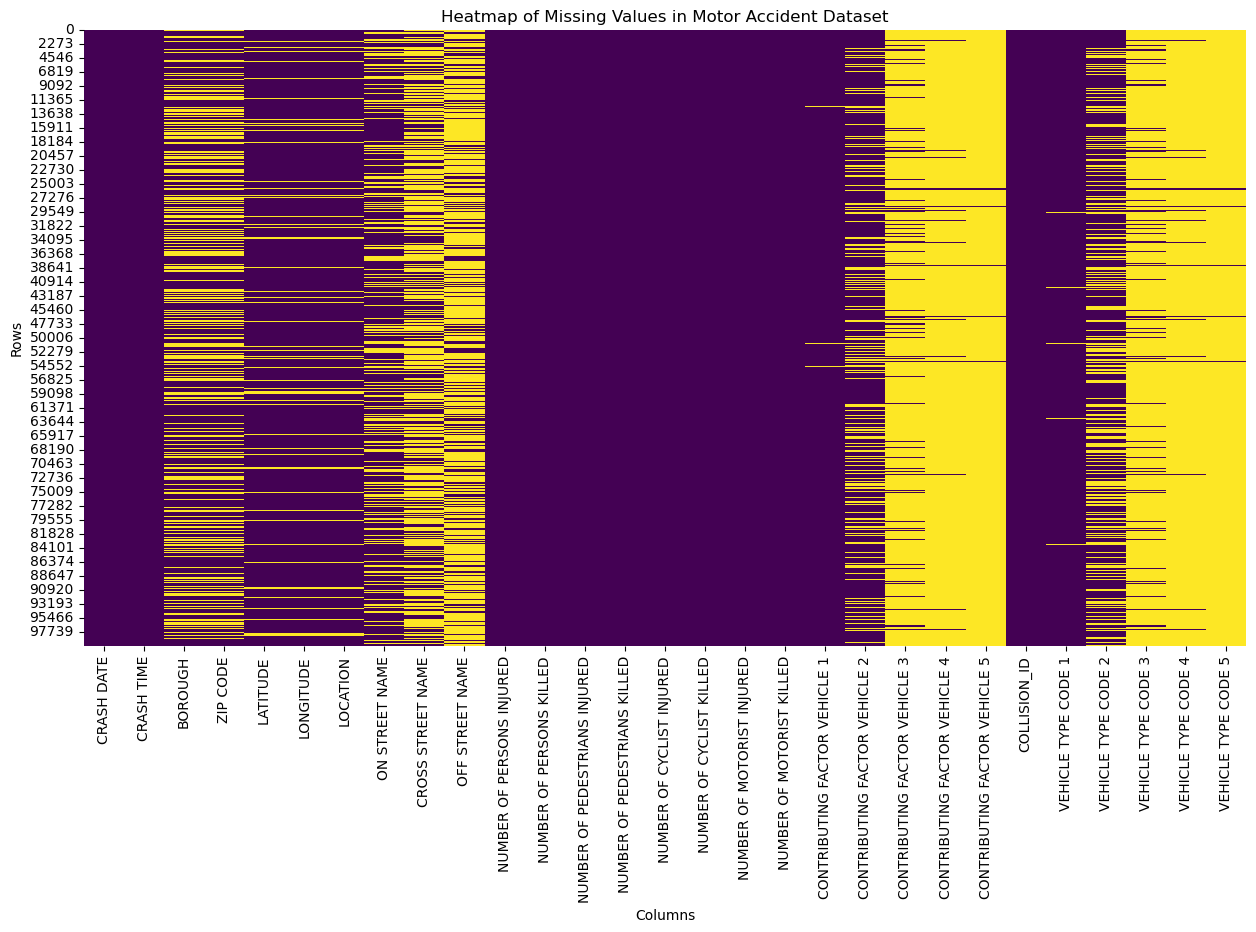

In [11]:
# Visualizing null values in dataset
# Creating a boolean dataframe that indicates missing values
missing_df = motor_accident_df.isnull()

# Creates a heatmap using the missing_df created
plt.figure(figsize=(15, 8))
sns.heatmap(missing_df, cbar=False, cmap="viridis") # 'viridis' shows missing in different color
plt.title("Heatmap of Missing Values in Motor Accident Dataset")
plt.xlabel("Columns")
plt.ylabel("Rows")
plt.show()

Looking at the heatmap created above, we are able to determine that there are some unusable rows due to the sheer amount of missing values in their fields. Luckily, the columns that I plan on using for analysis seem to have enough information filled in to be utilized for creating visuals and performing analysis. Seeing that none of the columns with missing values that deal with locations can be imputed, it would be wise to drop any entries that have null values in those entries if they are going to be required for analysis, such as latitude and longitude of the accident.

In [12]:
motor_accident_df.isnull().sum()

CRASH DATE                           0
CRASH TIME                           0
BOROUGH                          34389
ZIP CODE                         34400
LATITUDE                          7939
LONGITUDE                         7939
LOCATION                          7939
ON STREET NAME                   27124
CROSS STREET NAME                53639
OFF STREET NAME                  72877
NUMBER OF PERSONS INJURED            0
NUMBER OF PERSONS KILLED             0
NUMBER OF PEDESTRIANS INJURED        0
NUMBER OF PEDESTRIANS KILLED         0
NUMBER OF CYCLIST INJURED            0
NUMBER OF CYCLIST KILLED             0
NUMBER OF MOTORIST INJURED           0
NUMBER OF MOTORIST KILLED            0
CONTRIBUTING FACTOR VEHICLE 1      503
CONTRIBUTING FACTOR VEHICLE 2    22599
CONTRIBUTING FACTOR VEHICLE 3    89698
CONTRIBUTING FACTOR VEHICLE 4    97220
CONTRIBUTING FACTOR VEHICLE 5    99153
COLLISION_ID                         0
VEHICLE TYPE CODE 1               1195
VEHICLE TYPE CODE 2      

### Tidiness Issue 1: Crash Date and Time Separation

The first tidiness issue that I noticed that will need to be addressed is the fact that the CRASH DATE and CRASH TIME columns have been separated into two seperate object columns rather than being stored into a single datatime type. This will be addressed, as there are many usefule datetime functions that can be utilized

In [13]:
# Visually showing the CRASH DATE and CRASH TIME are seperate columns rather than one
motor_accident_df[['CRASH DATE', 'CRASH TIME']].head()

,CRASH DATE,CRASH TIME
0,09/11/2021,2:39
1,03/26/2022,11:45
2,11/01/2023,1:29
3,06/29/2022,6:55
4,09/21/2022,13:21


### Tidiness Issue 2: Unneeded LOCATION Column

The next tidiness issue that will be addressed is that fact that there is a column for latitude, longitude, and location. The location column is just the latitude and longitude values stored together in an object, sot it will not be as usable as the latitude and longitude columns which are stored as float types

In [14]:
# Inspecting the dataframe visually
print(motor_accident_df[['LATITUDE', 'LONGITUDE', 'LOCATION']].sample(5))

        LATITUDE  LONGITUDE                LOCATION
29980  40.672073  -73.91135  (40.672073, -73.91135)
44540  40.599922  -73.93985  (40.599922, -73.93985)
88932  40.865765  -73.86735  (40.865765, -73.86735)
97500  40.738476  -73.74885  (40.738476, -73.74885)
34369  40.712320  -73.73202   (40.71232, -73.73202)


In [15]:
print(motor_accident_df['LOCATION'].dtype)

object


> As shown above, we can see that the LOCATION column of the dataset is just the LATITUDE and LONGITUDE columns brought together and stored as an object

## Step 3: Clean Data

Most of the cleaning will be performed on the motor_accidtnes_df since the nyc_weather_df ahd all the information required pulled at the start. Upon inspection of the nyc_weather_df, there appers to be no null values that need to be addressed for analysis.

In [16]:
# Copy of the motor_accident_df and nyc_weather_df dataframes
motor_accident_cleaned = motor_accident_df.copy()
nyc_weather_cleaned = nyc_weather_df.copy()

### Quality Issue 1: Mixed Data Types in Motor Accident DataFrame

In [17]:
# Converts the CRASH DATE to a datetime data type
motor_accident_cleaned['CRASH DATE'] = pd.to_datetime(motor_accident_cleaned['CRASH DATE'], errors='coerce')#'coerce' will turn unparseable dates int NaT (Not a Time)

# Converts NUMBER OF PERSONS INJURED and NUMBER OF PERSONS KILLED to integers
# First, fill NaN values with 0, as NaN likely means no injuries/fatalities
motor_accident_cleaned['NUMBER OF PERSONS INJURED'] = motor_accident_cleaned['NUMBER OF PERSONS INJURED'].fillna(0).astype('int64')
motor_accident_cleaned['NUMBER OF PERSONS KILLED'] = motor_accident_cleaned['NUMBER OF PERSONS KILLED'].fillna(0).astype('int64')

In [18]:
motor_accident_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 29 columns):
 #   Column                         Non-Null Count   Dtype         
---  ------                         --------------   -----         
 0   CRASH DATE                     100000 non-null  datetime64[ns]
 1   CRASH TIME                     100000 non-null  object        
 2   BOROUGH                        65611 non-null   object        
 3   ZIP CODE                       65600 non-null   float64       
 4   LATITUDE                       92061 non-null   float64       
 5   LONGITUDE                      92061 non-null   float64       
 6   LOCATION                       92061 non-null   object        
 7   ON STREET NAME                 72876 non-null   object        
 8   CROSS STREET NAME              46361 non-null   object        
 9   OFF STREET NAME                27123 non-null   object        
 10  NUMBER OF PERSONS INJURED      100000 non-null  int64         
 11  N

In [19]:
# Assertions created to validate the datatypes were change to the correct type
assert motor_accident_cleaned['CRASH DATE'].dtype == 'datetime64[ns]'
assert motor_accident_cleaned['NUMBER OF PERSONS INJURED'].dtype == 'int64'
assert motor_accident_cleaned['NUMBER OF PERSONS KILLED'].dtype == 'int64'

### Quality Issue 2: Missing Values in Motor Accident DataFrame

In [20]:
# Created a list of columns to fill NaN entries to 0
injury_fatality_columns = ['NUMBER OF PERSONS INJURED', 'NUMBER OF PERSONS KILLED']

# Created a for loop to loop through list provided above and change all of the NaN values to 0
for col in injury_fatality_columns:
    motor_accident_cleaned[col] = pd.to_numeric(motor_accident_cleaned[col], errors='coerce').fillna(0).astype(int)

> I decided to handle the code above this way so that if analysis in the future required any of the other number of people injured/killed columns that are provided, they could be added to the list of columns and the loop would fill all na values in all listed columns

In [21]:
# Drops an entry if either the latitude or longitude is missing
motor_accident_cleaned.dropna(subset=['LATITUDE', 'LONGITUDE'], how='any', inplace=True)

> As I cannot get a pinpoint location of an accident using just the latitude or the longitude, I dropped all entries in the dataset that had one or the other missing since it wouldn't be usable for analysis

In [22]:
# Validated cleaning process worked using assert statements
assert motor_accident_cleaned['NUMBER OF PERSONS INJURED'].isnull().sum() == 0
assert motor_accident_cleaned['NUMBER OF PERSONS KILLED'].isnull().sum() == 0
assert motor_accident_cleaned['LATITUDE'].isnull().sum() == 0
assert motor_accident_cleaned['LONGITUDE'].isnull().sum() == 0

### Tidiness Issue 1: Crash Date and Time Separation

In [23]:
# Create a new string column to hold the combined CRASH DATE and CRASH TIME columns
motor_accident_cleaned['CRASH DATETIME STR'] = motor_accident_cleaned['CRASH DATE'].dt.strftime('%Y-%m-%d') + ' ' + motor_accident_cleaned['CRASH TIME'].astype(str)

# Convert this placeholder column into a proper datetime object
motor_accident_cleaned['CRASH DATETIME'] = pd.to_datetime(motor_accident_cleaned['CRASH DATETIME STR'], errors='coerce')

# Drop the old CRASH DATE, CRASH TIME, and placeholder CRASH DATETIME STR columns from the dataset
motor_accident_cleaned.drop(columns=['CRASH DATE', 'CRASH TIME', 'CRASH DATETIME STR'], inplace=True)

> In the code above, I create a placeholder column that will hold the datetime in string format and formatted by YYYY-MM-DD. Once the cell is created and is holding the date and time put together, I then create a new CRASH DATETIME column that stores the infomation in the CRASH DATETIME STR but is stored as a datetime data type. Once this is done, all of the unneeded columns are then dropped from the dataset

In [24]:
#Sets the new CRASH DATETIME column to the front when printing data
cols = motor_accident_cleaned.columns.tolist()

#Removes the column CRASH DATETIME that is at the end of dataset
cols.remove('CRASH DATETIME')

#Inserts the CRASH DATETIME to the beginning of the dataset
cols.insert(0, 'CRASH DATETIME')

#Applies this change to the cleaned dataset
motor_accident_cleaned = motor_accident_cleaned[cols]

> In the code above, I am simply reordering the layout of the dataset so the CRASH DATETIME columns is in the front.

In [25]:
# Checks the CRASH DATETIME column was added and is of the correct datatype
motor_accident_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Index: 92061 entries, 2 to 99999
Data columns (total 28 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   CRASH DATETIME                 92061 non-null  datetime64[ns]
 1   BOROUGH                        63752 non-null  object        
 2   ZIP CODE                       63743 non-null  float64       
 3   LATITUDE                       92061 non-null  float64       
 4   LONGITUDE                      92061 non-null  float64       
 5   LOCATION                       92061 non-null  object        
 6   ON STREET NAME                 65859 non-null  object        
 7   CROSS STREET NAME              42790 non-null  object        
 8   OFF STREET NAME                26202 non-null  object        
 9   NUMBER OF PERSONS INJURED      92061 non-null  int32         
 10  NUMBER OF PERSONS KILLED       92061 non-null  int32         
 11  NUMBER OF PEDESTRIAN

### Tidiness Issue 2: Unneeded Columns

The first step I take when getting rid of all the unneeded columns in the dataset is create a function that will take in a list of columns that can be adjusted based on the analysis being performed. I created this function so that if the columns needed to be dropped changed, I will be able to just modify the list of columns variable created below rather than having to hard code the columns to drop every time analysis requirements change

In [28]:
# Function used to drop columns that are no longer needed
def drop_columns(columns_to_drop):
    # Name index used to show what entry is invalid for error message
    name_index = 0
    try:
        
        # First for loop just checks to see if the column is in dataset
        # and throws an exception if any entry in list isn't in dataset
        for col in columns_to_drop:   
            if col not in motor_accident_cleaned.columns:
                raise ValueError(f"Column '{col}' not found in Motor Accident Dataset!")
            name_index += 1
            
        # This loop will only run after first loop guarantees all items in
        # list are valid column names in dataset
        for col in columns_to_drop:
            motor_accident_cleaned.drop(col, inplace=True, axis=1)
        print(f"Sucessfully dropped all specified columns")
    except ValueError as e:
        print(f"Error: {e}")

In [29]:
# List of unneeded columns
unneeded_col_list = ['BOROUGH', 'ZIP CODE', 'LOCATION', 'ON STREET NAME', 'CROSS STREET NAME',
                 'OFF STREET NAME', 'NUMBER OF PEDESTRIANS INJURED', 'NUMBER OF PEDESTRIANS KILLED',
                 'NUMBER OF CYCLIST INJURED', 'NUMBER OF CYCLIST KILLED', 'NUMBER OF MOTORIST INJURED',
                 'NUMBER OF MOTORIST KILLED', 'CONTRIBUTING FACTOR VEHICLE 1', 'CONTRIBUTING FACTOR VEHICLE 2',
                 'CONTRIBUTING FACTOR VEHICLE 3', 'CONTRIBUTING FACTOR VEHICLE 4', 'CONTRIBUTING FACTOR VEHICLE 5',
                 'VEHICLE TYPE CODE 1', 'VEHICLE TYPE CODE 2', 'VEHICLE TYPE CODE 3', 'VEHICLE TYPE CODE 4',
                 'VEHICLE TYPE CODE 5']
drop_columns(unneeded_col_list)

Sucessfully dropped all specified columns


In [30]:
# Displays head to verify columns were dropped
motor_accident_cleaned.head()

,CRASH DATETIME,LATITUDE,LONGITUDE,NUMBER OF PERSONS INJURED,NUMBER OF PERSONS KILLED,COLLISION_ID
2,2023-11-01 01:29:00,40.621790,-73.970024,1,0,4675373
9,2021-09-11 09:35:00,40.667202,-73.866500,0,0,4456314
10,2021-12-14 08:13:00,40.683304,-73.917274,0,0,4486609
12,2021-12-14 17:05:00,40.709183,-73.956825,0,0,4486555
13,2021-12-14 08:17:00,40.868160,-73.831480,2,0,4486660


> As shown above, all the unneeded columns have now been dropped from the cleaned version of the dataset. This version of the dataset is now ready to be merged with the weather dataset

### Remove unnecessary variables and combine datasets

In [39]:
# Creates vairable to hold how many unique values there are
num_unique = motor_accident_cleaned['COLLISION_ID'].nunique()

# Subtracts the amount of unique counts from the total amount of entries
print(f"Number of duplicate entries: {len(motor_accident_cleaned) - num_unique}")

Number of duplicate entries: 0


> The first thing I do before merging the datasets together is ensure that there are no duplicate entries in the cleaned dataset using the primary key (COLLISION_ID)

In [40]:
motor_accident_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Index: 92061 entries, 2 to 99999
Data columns (total 6 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   CRASH DATETIME             92061 non-null  datetime64[ns]
 1   LATITUDE                   92061 non-null  float64       
 2   LONGITUDE                  92061 non-null  float64       
 3   NUMBER OF PERSONS INJURED  92061 non-null  int32         
 4   NUMBER OF PERSONS KILLED   92061 non-null  int32         
 5   COLLISION_ID               92061 non-null  int64         
dtypes: datetime64[ns](1), float64(2), int32(2), int64(1)
memory usage: 4.2 MB


In [41]:
# Drop any rows with nulls in the weather data
nyc_weather_cleaned.dropna(inplace=True)

# Converts the 'time' column to date objects
nyc_weather_cleaned['time'] = pd.to_datetime(nyc_weather_cleaned['time']).dt.date

# Renames the  'time' column to 'CRASH DATE ONLY' for the merge
nyc_weather_cleaned.rename(columns={'time': 'CRASH DATE ONLY'}, inplace=True)

# Creates a date only column for the puropse of the merge
motor_accident_cleaned['CRASH DATE ONLY'] = motor_accident_cleaned['CRASH DATETIME'].dt.date

# Merges the dataset with motor accidents on the left and weather on the right so data is filled to the accidents if available
merged_df = pd.merge(motor_accident_cleaned, nyc_weather_cleaned, on='CRASH DATE ONLY', how='left')

# Drop the temporary 'CRASH DATE ONLY' column from the merged_df
merged_df.drop(columns=['CRASH DATE ONLY'], inplace=True)

In [42]:
merged_df.head()

,CRASH DATETIME,LATITUDE,LONGITUDE,NUMBER OF PERSONS INJURED,NUMBER OF PERSONS KILLED,COLLISION_ID,temperature_2m_max,temperature_2m_min,precipitation_sum,rain_sum,snowfall_sum,precipitation_hours,weather_code,wind_speed_10m_max,wind_gusts_10m_max,wind_direction_10m_dominant
0,2023-11-01 01:29:00,40.621790,-73.970024,1,0,4675373,9.4,3.4,2.8,2.8,0.0,12.0,53,22.0,44.6,333
1,2021-09-11 09:35:00,40.667202,-73.866500,0,0,4456314,24.7,12.9,0.0,0.0,0.0,0.0,3,16.6,34.2,246
2,2021-12-14 08:13:00,40.683304,-73.917274,0,0,4486609,10.4,3.1,0.0,0.0,0.0,0.0,3,18.5,31.3,322
3,2021-12-14 17:05:00,40.709183,-73.956825,0,0,4486555,10.4,3.1,0.0,0.0,0.0,0.0,3,18.5,31.3,322
4,2021-12-14 08:17:00,40.868160,-73.831480,2,0,4486660,10.4,3.1,0.0,0.0,0.0,0.0,3,18.5,31.3,322


### Creating Metrics for Analysis: Accident Rates

In [43]:
# Creating a weather code column that stores the string representation (i.e. 53 = Drizzle: Moderate) for analysis purposes
# All weather codes provided are found one the open-meteo website
weather_code_mapping = {
    0: 'Clear sky', 1: 'Mainly clear', 2: 'Partly cloudy', 3: 'Overcast',
    45: 'Fog', 48: 'Depositing rime fog', 51: 'Drizzle: Light',
    53: 'Drizzle: Moderate', 55: 'Drizzle: Dense',
    56: 'Freezing Drizzle: Light', 57: 'Freezing Drizzle: Dense',
    61: 'Rain: Light', 63: 'Rain: Moderate', 65: 'Rain: Heavy',
    66: 'Freezing Rain: Light', 67: 'Freezing Rain: Heavy',
    71: 'Snow fall: Light', 73: 'Snow fall: Moderate', 75: 'Snow fall: Heavy',
    77: 'Snow grains', 80: 'Rain showers: Light', 81: 'Rain showers: Moderate',
    82: 'Rain showers: Violent', 85: 'Snow showers: Light',
    86: 'Snow showers: Heavy', 95: 'Thunderstorm: Slight or moderate',
    96: 'Thunderstorm with slight hail', 99: 'Thunderstorm with heavy hail'
}
if 'Weather Description' not in merged_df.columns:
    merged_df['Weather Description'] = merged_df['weather_code'].map(weather_code_mapping)
    print(" 'Weather Description' column created.")

 'Weather Description' column created.


In [44]:
#Defining weather categories for analysis
sunny_weather_types = ['Clear sky', 'Mainly clear']
snowy_weather_types = [
    'Snow fall: Light', 'Snow fall: Moderate', 'Snow fall: Heavy',
    'Snow showers: Light', 'Snow showers: Heavy', 'Snow grains'
]

> In the columns above, I created a dictonary of all the weather codes that are listed on the open-meteo website. Once that is created, I test to see if the column Weather Description already exists in the merged dataset. If it does exist, nothing happens. If it does not exist, it is then created and the values are entered using the code assigned to the weather_code column. I then create two lists that contain the weather description of sunny days and snowy days for analysis.

In [45]:
# Filtering the DataFrame to include only these specific weather types for efficiency
comparison_df = merged_df[
    merged_df['Weather Description'].isin(sunny_weather_types + snowy_weather_types)
].copy()

In [46]:
# Extracting date component for counting unique days
comparison_df['CRASH DATE ONLY'] = comparison_df['CRASH DATETIME'].dt.date

In [47]:
# Calculating the total number of accidents for each weather description
total_accidents_by_weather = comparison_df.groupby('Weather Description').agg(
    Total_Accidents=('COLLISION_ID', 'count')
).reset_index()
total_accidents_by_weather

,Weather Description,Total_Accidents
0,Clear sky,1490
1,Mainly clear,3309
2,Snow fall: Heavy,777
3,Snow fall: Light,1982
4,Snow fall: Moderate,1533


> In the cells above I created a new dataframe that will house the infomation of the weather description and the total amount of accidents that occured in that weather condition.

In [48]:
# Calculate the number of unique days for each weather description
unique_days_by_weather = comparison_df.groupby('Weather Description')['CRASH DATE ONLY'].nunique().reset_index()
unique_days_by_weather.rename(columns={'CRASH DATE ONLY': 'Number_of_Unique_Days'}, inplace=True)

unique_days_by_weather

,Weather Description,Number_of_Unique_Days
0,Clear sky,18
1,Mainly clear,25
2,Snow fall: Heavy,8
3,Snow fall: Light,18
4,Snow fall: Moderate,23


In [49]:
# Merge these two aggregated dataframes to get counts and unique days together
weather_impact_rates = pd.merge(total_accidents_by_weather, unique_days_by_weather, on='Weather Description', how='left')
weather_impact_rates

,Weather Description,Total_Accidents,Number_of_Unique_Days
0,Clear sky,1490,18
1,Mainly clear,3309,25
2,Snow fall: Heavy,777,8
3,Snow fall: Light,1982,18
4,Snow fall: Moderate,1533,23


In [50]:
# Calculate the 'Accidents Per Day' metric for analysis
weather_impact_rates['Accidents_Per_Day'] = weather_impact_rates['Total_Accidents'] / weather_impact_rates['Number_of_Unique_Days']
weather_impact_rates['Accidents_Per_Day']

0     82.777778
1    132.360000
2     97.125000
3    110.111111
4     66.652174
Name: Accidents_Per_Day, dtype: float64

> Once the new dataframe is set up, I then go on to create another simple dataframe that houses the number of unique days in a season. This is important since there are more sunny days that happen in a year than there are snowy days, so just looking at totals will not give valueable insights. Once the second new dataframe is created, I then merge these together to store all the information together.

In [51]:
#Creates two categories for sunny/clear and snowy conditions for analysis
weather_impact_rates['Category'] = weather_impact_rates['Weather Description'].apply(
    lambda x: 'Snowy Conditions' if x in snowy_weather_types else 'Sunny/Clear Conditions'
)

In [52]:
#Aggregating by the combined category for analysis
avg_accidents = weather_impact_rates.groupby('Category').agg(
    Total_Accidents=('Total_Accidents', 'sum'),
    Number_of_Unique_Days=('Number_of_Unique_Days', 'sum')
).reset_index() # Reset index to make 'Category' a column

avg_accidents['Accidents_Per_Day'] = avg_accidents['Total_Accidents'] / avg_accidents['Number_of_Unique_Days']
avg_accidents = avg_accidents.sort_values(by='Accidents_Per_Day', ascending=False)

In [53]:
avg_accidents

,Category,Total_Accidents,Number_of_Unique_Days,Accidents_Per_Day
1,Sunny/Clear Conditions,4799,43,111.604651
0,Snowy Conditions,4292,49,87.591837


> The final thing I do is create two 'bins' called sunny/clear conditions and snowy conditions. Using the infomation that was stored by merging the datasets together, I was able to calculate an estimate of how many accidents happened per day based on the weather condition. This is only an estimate since at the beginning of the notbook I consolidated down to 100000 recored rather than the original 2 million records that were available.

### Creating Metrics for Analysis: Accident Severity

The first thing I will be doing is creating a metrict that shows the severity of the accident. With the dataset that I pulled, I can create a simple metric that uses injuries as a score of 1 and fatalities as a score of 20 since someone dying is much more severe than an injury. Since these entries do no include how severe the injuries are, I will set the score to 1 for simple analysis.

> The cells below that are creating the metric for accident severity have the same general layout as the code above that created the average of accidents that happened based on the weather conditions. In this case, I create a severity metric that will measure how severe the accident was.

In [54]:
# Creating a severity score
merged_df['Severity_Score'] = (
    merged_df['NUMBER OF PERSONS INJURED'] * 1 +
    merged_df['NUMBER OF PERSONS KILLED'] * 20)

In [55]:
# Creates a Total_Affected_Persons column that shows how many were injured or killed in an accident
merged_df['Total_Affected_Persons'] = (
    merged_df['NUMBER OF PERSONS INJURED'] + 
    merged_df['NUMBER OF PERSONS KILLED'])

merged_df['Total_Affected_Persons'].head(10)

0    1
1    0
2    0
3    0
4    2
5    0
6    0
7    0
8    0
9    0
Name: Total_Affected_Persons, dtype: int32

> In creating the severity score, I decided to rate all injured people with a score of 1. I did this since the original dataset did not expand no how sever the injury was. It could have been anything from a minor scrape that needed to be reported for insurance reasons, to someone ending up paralyzed or in a coma. Due to this range of possibilities, I stick with the generel 1 rating for the purpose of this notebook. I scored any deaths that occured in the accident with a score of 20. This number can be adjusted however desired as most metrics I found online range a death from anywhere beetween 10-100 on the severity scale.

In [56]:
# Groups by Weather Description and calculates that average Severity_Score
average_severity_by_weather = merged_df.groupby('Weather Description').agg(
    Average_Severity_Score=('Severity_Score', 'mean')
).sort_values(by='Average_Severity_Score', ascending=False)#Easily shows what condition has highest severity average
average_severity_by_weather

,Average_Severity_Score
Weather Description,
Mainly clear,0.543367
Drizzle: Light,0.541855
Partly cloudy,0.539216
Overcast,0.537179
Rain: Light,0.537091
Snow fall: Light,0.536327
Rain: Heavy,0.527655
Clear sky,0.527517
Drizzle: Dense,0.523083


In [57]:
merged_df['Weather_Category'] = merged_df['Weather Description'].apply(
    lambda x: 'Sunny/Clear Conditions' if x in sunny_weather_types else
              ('Snowy Conditions' if x in snowy_weather_types else None)
)

In [58]:
average_severity_combined = merged_df.dropna(subset=['Weather_Category']).groupby('Weather_Category').agg(
    Average_Severity_Score=('Severity_Score', 'mean'),
    Total_Accidents=('COLLISION_ID', 'count') # Adding total accidents for context in the printout
).reset_index().sort_values(by='Average_Severity_Score', ascending=False)

average_severity_combined

,Weather_Category,Average_Severity_Score,Total_Accidents
1,Sunny/Clear Conditions,0.538446,4799
0,Snowy Conditions,0.462488,4292


## Step 4: Update Data Store

In [59]:
# Creates new CSV file that contains all cleaned and prepared data for analysis
merged_df.to_csv('cleaned_and_merged_data.csv', index=True)

## Step 5: Analysis

### Research Question 1:

Do more accidents occur and with a higher severity during snowy/partly snowy weather or during clear sunny weather?

C:\Users\rharv\AppData\Local\Temp\ipykernel_30132\4011250175.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


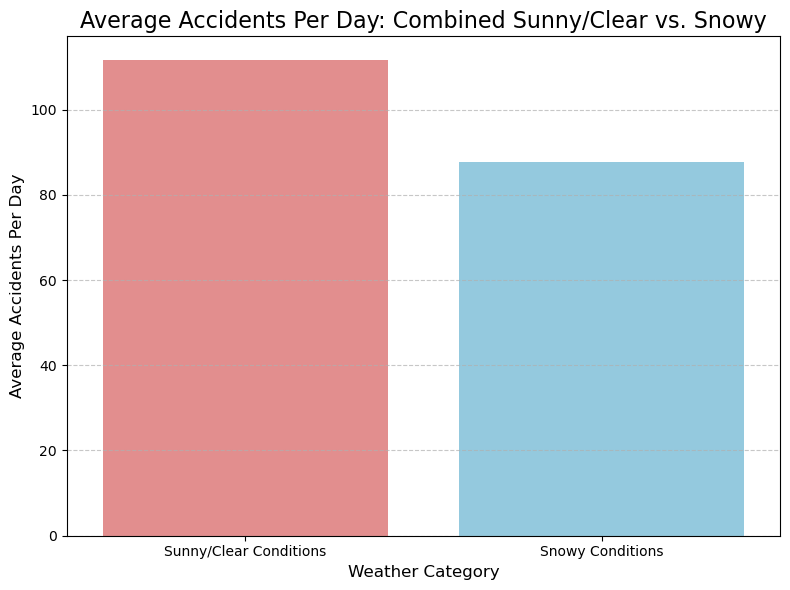

In [60]:
#Creates a bar plot to visualize findings
plt.figure(figsize=(8, 6))
sns.barplot(
    x='Category',
    y='Accidents_Per_Day',
    data=avg_accidents,
    palette=['lightcoral', 'skyblue'] # Order based on which is higher value for visual clarity
)
plt.title('Average Accidents Per Day: Combined Sunny/Clear vs. Snowy', fontsize=16)
plt.xlabel('Weather Category', fontsize=12)
plt.ylabel('Average Accidents Per Day', fontsize=12)
plt.xticks(rotation=0, ha='center', fontsize=10)
plt.yticks(fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

> Answer to research question: As shown using the visual above, it seems that more accidents in fact happen when the weather condition is sunny and clear rather than when conditions are snowy. Going into this project, I was under the assumption that snowy weather conditions would cause more accidents on the roads. After looking at this visual and seeing on average that this is not the case it does raise some more questions that can be investigated in the future.

The next thing I will be looking into is the crash severity average in certain weather conditions

C:\Users\rharv\AppData\Local\Temp\ipykernel_30132\3722638141.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


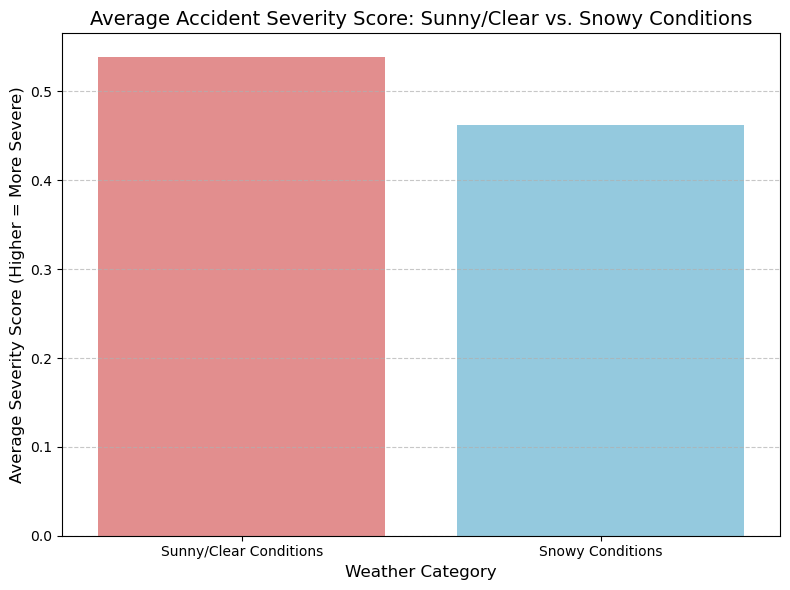

In [61]:
# Creates a visual using the severity metric created earlier
plt.figure(figsize=(8, 6)) # A compact figure size as there are only two bars
sns.barplot(
    x='Weather_Category',
    y='Average_Severity_Score',
    data=average_severity_combined,
    # Assign specific colors for clarity: red for snowy, blue for clear
    palette=['lightcoral', 'skyblue']
)
plt.title('Average Accident Severity Score: Sunny/Clear vs. Snowy Conditions', fontsize=14)
plt.xlabel('Weather Category', fontsize=12)
plt.ylabel('Average Severity Score (Higher = More Severe)', fontsize=12)
plt.xticks(rotation=0, ha='center', fontsize=10) # Keep labels horizontal
plt.yticks(fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7) # Add a grid for easier value comparison
plt.tight_layout() # Adjust layout to prevent labels from being cut off
plt.show()

> Answer to research question: Looking at this visual it appears that the most severe accidents tend to happen in sunny/clear weather. The difference between the two is quite close. The reason for this could be that in snowy conditions, accidents tend to be a car sliding on ice or slush and causing a minor accident with no injuries. To gain more insight as to why the data points towards this conclusion, more investigating would need to be perfomed before any meaninful reasonings could be extracted.

### Research Question 2:

What weather condition causes accidents the most frequently?

The first step I take to answer this question is to create an aggregation that brings all of the different weather conditions together and get the average accidents per day using the total amount of accidents per day and the amount of days.

In [65]:
# First, ensure you have the 'CRASH DATE ONLY' column
if 'CRASH DATE ONLY' not in merged_df.columns:
    merged_df['CRASH DATE ONLY'] = merged_df['CRASH DATETIME'].dt.date

# Now, run the aggregation to get the necessary counts
all_weather_analysis = merged_df.groupby('Weather Description').agg(
    Total_Accidents=('COLLISION_ID', 'count'),
    Number_of_Unique_Days=('CRASH DATE ONLY', 'nunique')
).reset_index()

# Display the result
print(all_weather_analysis.to_string())

    Weather Description  Total_Accidents  Number_of_Unique_Days
0             Clear sky             1490                     18
1        Drizzle: Dense             2686                     21
2        Drizzle: Light            16617                    107
3     Drizzle: Moderate             7484                     44
4          Mainly clear             3309                     25
5              Overcast            34011                    283
6         Partly cloudy             3264                     23
7           Rain: Heavy             2712                     15
8           Rain: Light             6902                     54
9        Rain: Moderate             9294                     66
10     Snow fall: Heavy              777                      8
11     Snow fall: Light             1982                     18
12  Snow fall: Moderate             1533                     23


After creating my aggregation, I then calculate the average accidents per day in each weather condition, and create my visual to display findings.

C:\Users\rharv\AppData\Local\Temp\ipykernel_30132\1013247873.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


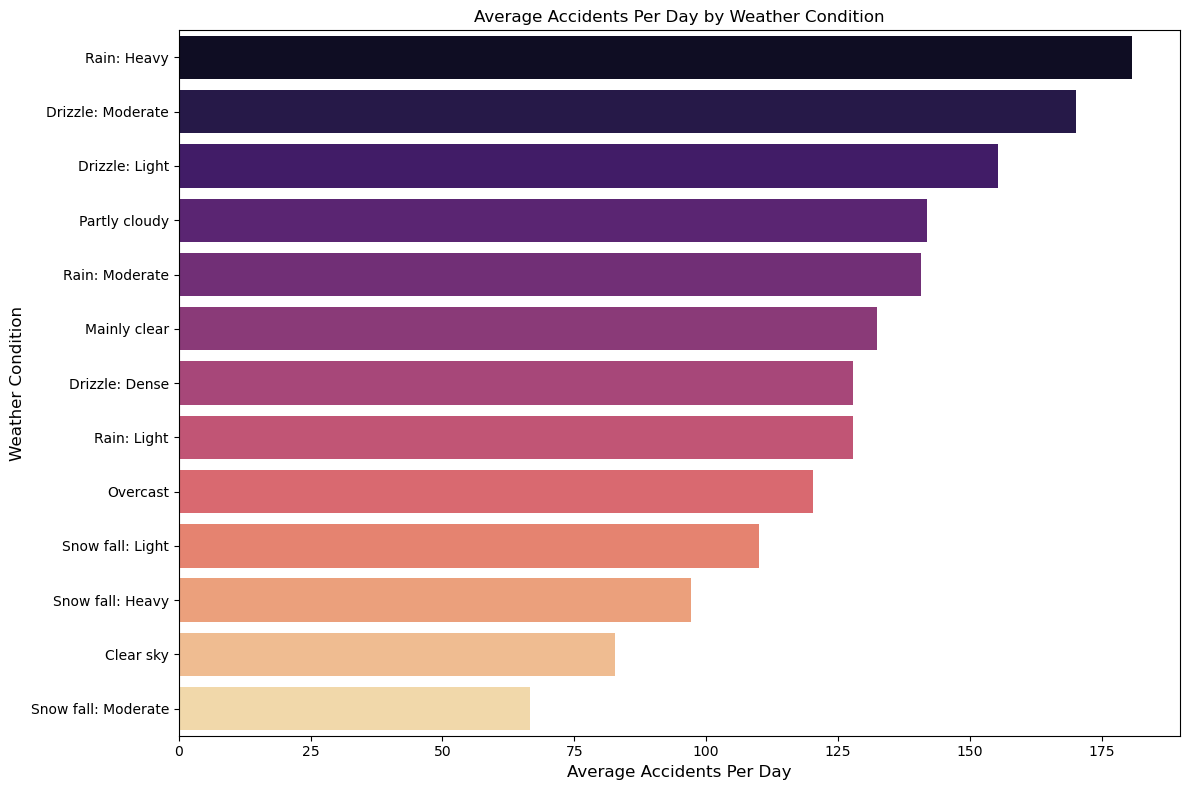

In [68]:
# Calculate normalized metrics
all_weather_analysis['Accidents_Per_Day'] = all_weather_analysis['Total_Accidents'] / all_weather_analysis['Number_of_Unique_Days']

# Sort Results
all_weather_analysis = all_weather_analysis.sort_values(by="Accidents_Per_Day", ascending=False)

# Create bar chart
plt.figure(figsize= (12, 8))
sns.barplot(
    x = "Accidents_Per_Day",
    y = "Weather Description",
    data = all_weather_analysis,
    palette = "magma"
)
plt.title("Average Accidents Per Day by Weather Condition", fontsize=12)
plt.xlabel("Average Accidents Per Day", fontsize= 12)
plt.ylabel("Weather Condition", fontsize= 12)
plt.tight_layout()

> Looking at the visual created above, we are able to see the the most frequent accidents happen during rainy conditions. More analysis will be conducted to get behind possible reasons that this is the case.

After creating my visual to display the accident frequency, I next move on to see what the average accident severity is for each weather condition

In [71]:
average_severity_by_weather

,Average_Severity_Score
Weather Description,
Mainly clear,0.543367
Drizzle: Light,0.541855
Partly cloudy,0.539216
Overcast,0.537179
Rain: Light,0.537091
Snow fall: Light,0.536327
Rain: Heavy,0.527655
Clear sky,0.527517
Drizzle: Dense,0.523083


C:\Users\rharv\AppData\Local\Temp\ipykernel_30132\172219402.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


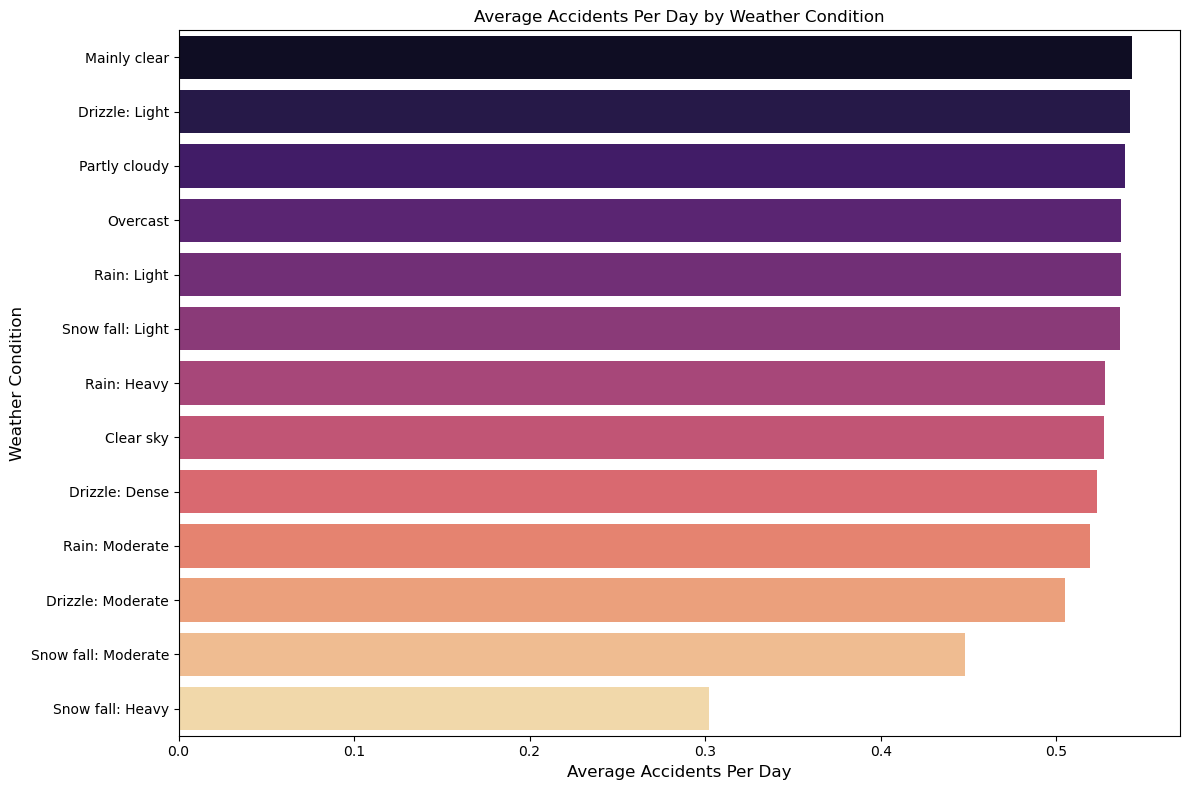

In [72]:
plt.figure(figsize= (12, 8))
sns.barplot(
    x = "Average_Severity_Score",
    y = "Weather Description",
    data = average_severity_by_weather,
    palette = "magma"
)
plt.title("Average Accidents Per Day by Weather Condition", fontsize=12)
plt.xlabel("Average Accidents Per Day", fontsize= 12)
plt.ylabel("Weather Condition", fontsize= 12)
plt.tight_layout()

> Looking at the visual created above, we are able to see that the spread of severity is quite even. The most frequent accidents appear to happen when the weather is mostly clear. However, what is intersting to see is that the least sever accidents happen during heavy snow fall. This could be due to the fact that everyone drives slower the more snow is around. More analyis will be conducted to determing potential reasons the data is spread the way it is.